In [12]:
import numpy as np
import pystan
import arviz

In [293]:
K = 22
MAXSKILLS = 4

with open('Y.npy', 'rb') as f:
    obsY = np.load(f).astype(int)
    
with open('idxY.npy', 'rb') as f:
    idxY = np.load(f).astype(int)
    
with open('T.npy', 'rb') as f:
    T = np.load(f)

I = T.shape[0]
T = np.array(T.tolist())
max_T = max(T)

In [295]:
obsData = (np.ones((I, max_T, K))).astype(int)
for i in range(I):
    for t in range(max_T):
        for s in range(MAXSKILLS):
            idx = int(idxY[i][t][s]) - 1
            if idx >= K:
                continue
            obsData[i][t][idx] = 1
obsData = obsData.astype(int)
obsData.shape

(1, 100, 22)

In [314]:
stan_model = """
data {
    int I;                          // Num. students
    int K;                          // Num. skills
    int max_T;                      // largest number in T
    int T[I];                       // #opportunities for each of the I students
    int MAXSKILLS;
    int idxY[I,max_T,MAXSKILLS];
    int y[I,max_T,K];               // output
}
parameters {
    vector[I] theta;
    vector<lower = 0, upper = 2.5>[K] lambda0;
    vector[K] lambda1;
    vector<lower = 0, upper = 1>[K] learn;
    vector<lower = 0, upper = 0.5>[K] g;
    vector<lower = 0.5, upper = 1>[K] ss;
}
transformed parameters {}
model {
    
    int alpha[I, K];
    int value;
    
    theta ~ normal(0, 1);
    lambda0 ~ uniform(0.0, 2.5);
    lambda1 ~ normal(0, 1);
    learn ~ beta(1, 1);
    ss ~ uniform(0.5, 1.0);
    g ~ uniform(0.0, 0.5);
    
    for (i in 1:I){
        for (t in 1:T[i]){
            for (k in 1:K){
                value ~ bernoulli(inv_logit(1.7 * lambda1[k] * (theta[i] - lambda0[k])));
                y[i, t, k] ~ bernoulli(value);
            }
        }
    }
}
generated quantities {}
"""

In [315]:
hotDINA = pystan.model.StanModel(model_code=stan_model, model_name="hotDINA")

ValueError: Failed to parse Stan model 'hotDINA_b86349597476f4c417c33becd35f532b'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:
No matches for: 

  real ~ bernoulli(real)

Available argument signatures for bernoulli:

  int ~ bernoulli(real)
  int ~ bernoulli(real[ ])
  int ~ bernoulli(vector)
  int ~ bernoulli(row_vector)
  int[ ] ~ bernoulli(real)
  int[ ] ~ bernoulli(real[ ])
  int[ ] ~ bernoulli(vector)
  int[ ] ~ bernoulli(row_vector)

Real return type required for probability function.
 error in 'unknown file name' at line 36, column 89
  -------------------------------------------------
    34:             for (k in 1:K){
    35:                 //alpha[i, k] ~ 
    36:                 value ~ bernoulli(inv_logit(1.7 * lambda1[k] * (theta[i] - lambda0[k])));
                                                                                                ^
    37:                 y[i, t, k] ~ bernoulli(value);
  -------------------------------------------------



In [313]:
hotDINA_fit = hotDINA.sampling(data={'I': I,
                                     'K': 22,
                                     'max_T': max_T,
                                     'T': T,
                                     'MAXSKILLS': 4,
                                     'idxY': idxY,
                                     'y': obsData
                                     },
                               iter=1000,
                               chains=4, 
                               warmup=500, 
                               n_jobs=1)

RuntimeError: Initialization failed.

In [151]:
obsData.shape

(3, 367, 22)

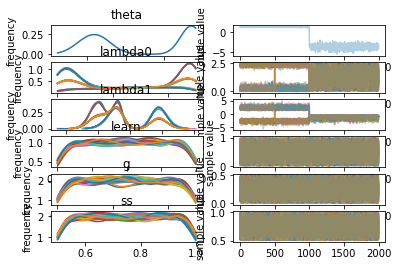

In [309]:
p = hotDINA_fit.plot()

In [310]:
print(hotDINA_fit)

Inference for Stan model: hotDINA_b4cd469f555eb3bee64b240d79e08c43.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]     -1.11    1.79   2.57  -4.58  -3.63  -0.42   1.42   1.55      2   6.68
lambda0[1]    1.85    0.39   0.74   0.15   1.32   2.24   2.42   2.49      4    1.5
lambda0[2]    1.31    0.56   0.92   0.02   0.32   1.37   2.29   2.49      3   1.92
lambda0[3]    0.75    0.42   0.77 9.8e-3   0.13   0.37   1.33   2.38      3   1.53
lambda0[4]    0.77    0.42   0.76   0.01   0.14   0.39   1.39   2.36      3   1.59
lambda0[5]    0.76    0.42   0.76   0.01   0.13   0.41   1.33    2.4      3   1.57
lambda0[6]     1.3    0.56   0.92   0.02   0.31   1.35    2.3   2.49      3   1.93
lambda0[7]    0.76    0.42   0.78   0.01   0.14   0.38   1.36    2.4      3   1.53
lambda0[8]    1.31    0.56   0.93   0.03   0.31    1.4   2.29   2.49 

max_T

In [98]:
max_T

367

In [104]:
obsY.shape

(3, 367, 4)

In [11]:
stan_model = """
data {
    
    int I;       // Num. students
    int K;       // Num. skills
    int max_T;   // largest number in T
    int T[I]; // #opportunities for each of the I students
    int MAXSKILLS;
    
    // int idxY[I,max_T,MAXSKILLS];
    
    int y[I,max_T];   // output
    
}
parameters {
    // Priors
    vector[I] theta;
    vector<lower = 0, upper = 2.5>[K] lambda0;
    vector[K] lambda1;
    vector<lower = 0, upper = 1>[K] learn;
    vector<lower = 0, upper = 0.5>[K] g;
    vector<lower = 0.5, upper = 1>[K] ss;
}
transformed parameters {}
model {
    
    int alpha[I,max_T];
    real value;
    int idx;
    real py[I, max_T];
    
    theta ~ normal(0, 1);
    lambda0 ~ uniform(0.0, 2.5);
    lambda1 ~ normal(0, 1);
    learn ~ beta(1, 1);
    ss ~ uniform(0.5, 1.0);
    g ~ uniform(0.0, 0.5);
    
    for (i in 1:I){
        // t = 1
        value = inv_logit(1.7 * lambda1[i] * (theta[i] - lambda0[i]));
        alpha[i, 1] ~ bernoulli(value);
        py[i, 1] = pow(ss[i], alpha[i,1]) * pow(g[i], (1-alpha[i,1]));
        
        for (t in 1:T[i]){
            y[i,t] ~ bernoulli(py[i, 1]);
        }
    }
}
generated quantities {}
"""

In [12]:
hotDINA = pystan.model.StanModel(model_code=stan_model, model_name="hotDINA")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL hotDINA_cfb91dd7eaa9f8b761b2b94f8f9d8cf3 NOW.


In [9]:
y = np.ones((I, max_T)).astype(int)

In [10]:
hotDINA_fit = hotDINA.sampling(data={'I': 3,
                                     'K': 22,
                                     'max_T': max_T,
                                     'T': T,
                                     'MAXSKILLS': 4,
                                     'y': y
                                     },
                               iter=1000, 
                               warmup=500)

RuntimeError: Exception: mismatch in number dimensions declared and found in context; processing stage=data initialization; variable name=y; dims declared=(3,367,4); dims found=(3,367)  (in 'unknown file name' at line 12)
